In [1]:
from wft import fetch_yf_data, WalkForward, asses_perf
from wft import Visualization as vis
import pandas as pd
import numpy as np

In [2]:
def compute_atr(high: pd.Series, low: pd.Series, close: pd.Series, period: int = 14) -> pd.Series:
    # Calculate the True Range (TR)
    high_low = high - low
    high_close_prev = (high - close.shift()).abs()
    low_close_prev = (low - close.shift()).abs()

    tr = pd.concat([high_low, high_close_prev, low_close_prev], axis=1).max(axis=1)

    # Calculate the ATR
    atr = tr.ewm(span=period, min_periods=1, adjust=False).mean() 
    return atr

def compute_indipendet_variables(ohlc: pd.DataFrame, lookahead:int = 1) -> pd.DataFrame:
    # data is already in log form
    open   = ohlc['Open']
    close  = ohlc['Close']
    low    = ohlc['Low']
    high   = ohlc['High']
    volume = ohlc['Volume']

    weekly_atr = compute_atr(high , low , close , 5)
    monthly_atr = compute_atr(high , low , close , 21)

    upper  = high - np.maximum(close , open)
    lower   = np.minimum(close , open)  - low
    assymmetry = upper - lower
    Intraday_assymmetry_standardized = assymmetry/ ( assymmetry.ewm(span = 20, adjust= False).std())

    vol_mean20 = volume.ewm(span = 20, adjust= False).mean()
    vol_surprise = volume  / vol_mean20 -1
    vol_surprise/=vol_surprise.ewm(span = 20, adjust= False).std()

    return5_over_atr = close.diff(5)/monthly_atr 

    df = pd.DataFrame(index = ohlc.index)

    df['return5_over_atr'] = return5_over_atr
    df['Intraday_assymmetry']   = Intraday_assymmetry_standardized
    df['vol_surprise']   = vol_surprise

    target =  close.diff(lookahead).shift(-lookahead)/weekly_atr 
    df.iloc[:20] = np.nan
    target.iloc[:20] = np.nan
    return df, target


The same variables (predictors and target)  explained in the file EXAMPLE_1 are used.

The new model:

- Includes interaction terms, squares, and cross products, resulting in 9 predictors.
- The model used for predictions remain unchanged => (OLS).
- During each training window, step-wise selection with cross-validation is used to select the optimal features. The 3 features that minimize the mean absolute error across each of the 5 folds are chosen.
- The variables X and y are standardized at each training step, with the transformation fitted on the training data and then applied at each case of the test set.

Expected Runtime <10s

p-value under H0: mean_return <=0 = 0.81 %
Mean Return: 0.098 %
Lower Confidence Interval: 0.03%
Upper Confidence Interval: 0.16%


c:\Users\andre\Desktop\VS-code_projects\Project\wft\plot_variables.py:237: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method = "ffill", inplace =True)


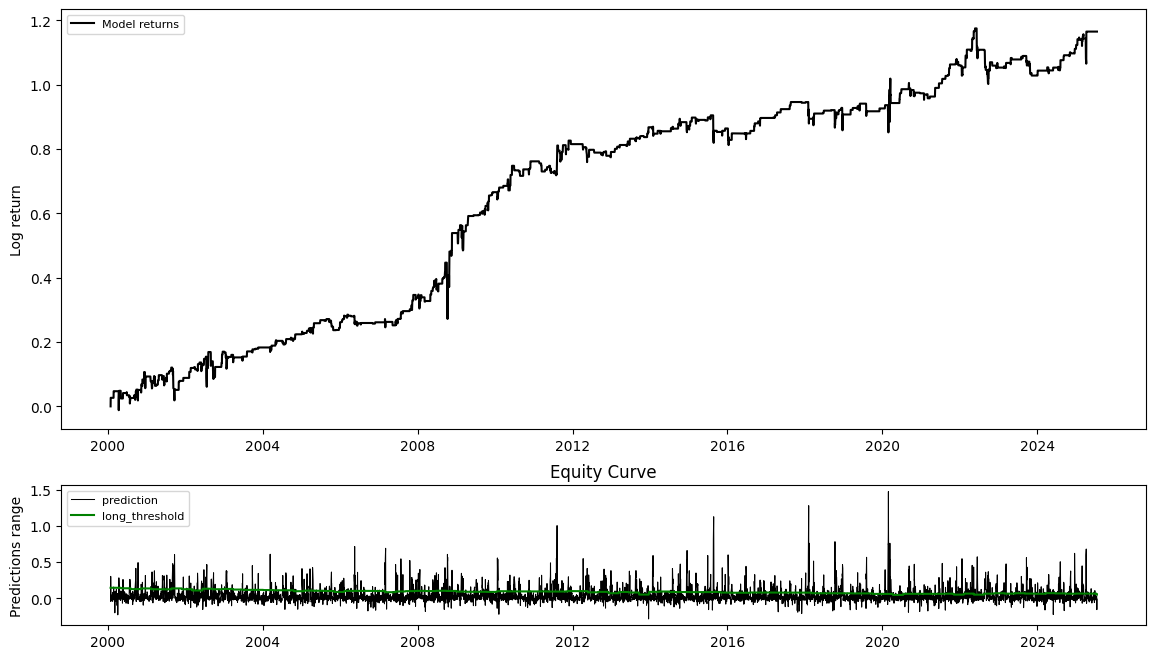

                                  mu_long_over_t  std_long  mu_long/std_long  params_ols
return5_over_atr                       -0.723726  2.033235         -0.355948   -0.036270
Intraday_assymmetry_vol_surprise        0.421511  1.223475          0.344520    0.040017
return5_over_atr_squared                4.657824  4.140325          1.124990    0.022856
       Annual Return %  Sharpe Ratio Annualized  Mean Return %  Total Return %  Max Drawdown %  Profit Factor  Sharpe Ratio benchmarck  P-value H0: mean_r <= 0  Time in the market %
Model              4.1                     1.11            0.1          116.54           17.51           1.31                     0.45                   0.0081                 18.59


In [ ]:
if __name__ == '__main__':

    data = fetch_yf_data('SPY')
    df,target = compute_indipendet_variables(data)
    ## Inititalize Pipiline Parameters
    inputs = df
    targets = target
    ohlc =data

    max_lookahead = 1
    model_components = ['ols']
    model_kwargs ={'ols':{'add_intercept':True}}
    stepwise_kwargs = {'max_terms':3, 'n_set_to_keep':1, 'eval_metric': 'mae', 'cv_folds':5}
    preprocess_variables =  [ 'X','y']
    preprocess_type = ['standardize']
    criterion = 'sharpe_ratio'
    min_trades = .1
    min_crit_value = 0
    WF = WalkForward(
                    inputs = inputs,
                    targets = targets,
                    ohlc = ohlc,
                    max_lookahead = max_lookahead,
                    model_components = model_components,
                    criterion = criterion,
                    min_trades = min_trades,
                    model_kwargs = model_kwargs,
                    min_crit_value = min_crit_value,
                    stepwise_kwargs= stepwise_kwargs,
                    interaction_terms=True,
                    side = 'long',
                    preprocess_variables = preprocess_variables,
                    preprocess_type = preprocess_type,
                        )

    # Perform WalkForward
    start_train = 252*5
    train_size =   0 # All past data
    step_size = 22*3 # Retrain every month 
    rets, long_stats, short_stats = WF.run(start_train= start_train,
                                           train_size = train_size,
                                           step_size=step_size, commision=0.0001)
    
    mean_ret = np.round(100*rets[rets!=0].mean(),3)
    p_value, ci = asses_perf.p_value_returns(rets.values)
    print(f'p-value under H0: mean_return <=0 = {(100*p_value):.2f} %')
    print(f'Mean Return: {mean_ret} %')
    print(f'Lower Confidence Interval: {(ci[0]):.2f}%')
    print(f'Upper Confidence Interval: {(ci[1]):.2f}%')  
    params_step_wise_last = long_stats['best_params_cv'].iloc[-1]

    vis.plot_single_equity_curve(rets,WF.model, WF.inputs[params_step_wise_last],
                                long_stats,short_stats  )
    threshold_dict = {'long': long_stats, 'short': short_stats}
    print(asses_perf.extrapolate_decision_model(WF.inputs[params_step_wise_last],
                                                WF.model, threshold_dict).to_string())
    print(asses_perf.performance_table(rets, 'Model', data['Close'].diff().fillna(0), 252*5).to_string())

Performance is Basically identical to step One, the final chosen predictor variables are:

- 5 Day standardized return
- (5 Day standardized return)*(Volume surprise)
- (5 Day standardized return)**2

There not seems to be any significant benefit in adding the interaction terms selected with step-wise cross validation